# Part 4: Segment cells and nuclei.

In the following notebook you will use the Mesmer algorithm to perfom cell and nuclear segmentation.

## 1. Import packages. 
### *This must be done every time the notebook is started or restarted.

In [1]:
# import required packages
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from alpineer import io_utils
from skimage import io
from ark.segmentation import marker_quantification, segmentation_utils
from ark.utils import deepcell_service_utils, plot_utils

## 2. Define directory paths. 
### *This must be done every time the notebook is started or restarted.

In [2]:
proc_dir = "C:/Users/smith6jt/KINTSUGI/data/1904_CC2B_Processed"
base_dir = "C:/Users/smith6jt/KINTSUGI/data/1904_CC2B_Segmentation"
print(f"Processed folder is {proc_dir}.")
print(f"Segmentation folder is {base_dir}.")

Processed folder is C:/Users/smith6jt/KINTSUGI/data/1904_CC2B_Processed.
Segmentation folder is C:/Users/smith6jt/KINTSUGI/data/1904_CC2B_Segmentation.


In [3]:
# set up file paths
tiff_dir = os.path.join(base_dir, "image_data")
cell_table_dir = os.path.join(base_dir, "segmentation/cell_table")
deepcell_input_dir = os.path.join(base_dir, "segmentation/deepcell_input")
deepcell_output_dir = os.path.join(base_dir, "segmentation/deepcell_output")
deepcell_visualization_dir = os.path.join(base_dir, "segmentation/deepcell_visualization")

### 2.1 This cell only needs to be run once.

In [4]:
# create directories if do not exist
for directory in [base_dir, tiff_dir, cell_table_dir, deepcell_input_dir, deepcell_output_dir, deepcell_visualization_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

## 3. Prepare Data for Mesmer

### 3.1 Tile Images to Size Below Mesmer Maximum.

In [5]:
def tile(input_folder, output_folder_base):
    
    files = os.listdir(input_folder)
    filename = os.path.join(input_folder, files[0])
    image = Image.open(filename)
    print(f"Using {filename} for image dimensions.")
    img_width, img_height = image.size
    print(f"Image width: {img_width} Image height: {img_height}")
        
    opt_tile_width = None
    opt_tile_height = None
    
    tile_dim = list(range(1500, 2041))
    for tile_dim in list(reversed(tile_dim)):
        if img_width % tile_dim == 0:
            opt_tile_width = tile_dim            
    if opt_tile_width:
        num_tiles_width = img_width // opt_tile_width
        print(f"Number of tiles, width: {num_tiles_width} {opt_tile_width}")
        new_width=img_width
    else:
        print("No optimal tile width between 1800-2040, finding optimal width to crop image.")
        new_width = list(range(img_width-100, img_width))
        for new_width in list(reversed(new_width)):
            tile_dim = list(range(1800, 2041))
            for tile_dim in list(reversed(tile_dim)):
                if new_width % tile_dim == 0:
                    opt_tile_width = tile_dim
                    num_tiles_width = new_width // opt_tile_width
                    break
            if opt_tile_width:
                break
        print(f"New image width: {new_width}")
        print(f"Number of tiles, width: {num_tiles_width} {opt_tile_width}")
                    
       
    tile_dim = list(range(1800, 2041))       
    for tile_dim in list(reversed(tile_dim)):
            if img_height % tile_dim == 0:
                opt_tile_height = tile_dim
    if opt_tile_height:
        num_tiles_height = img_height // opt_tile_height
        print(f"Number of tiles, height: {num_tiles_height} {opt_tile_height}")
        new_height=img_height
        
    else:
        print("No optimal tile height between 1800-2040, finding optimal height to crop image.")
        new_height = list(range(img_height-10, img_height))
        for new_height in list(reversed(new_height)):
            tile_dim = list(range(1800, 2041))
            for tile_dim in list(reversed(tile_dim)):
                if new_height % tile_dim == 0:
                    opt_tile_height = tile_dim
                    num_tiles_height = new_height // opt_tile_height
                    break
            if opt_tile_height:
                break
                
        print(f"New image height: {new_height}")
        print(f"Number of tiles, height: {num_tiles_height} {opt_tile_height}")
        
    for filename in files:
        if filename.endswith(('.tif')):

            image_path = os.path.join(input_folder, filename)
            image = Image.open(image_path)

            tile_index = 0

            for x in range(num_tiles_width):
                for y in range(num_tiles_height):
                
                    left = x * opt_tile_width
                    upper = y * opt_tile_height
                    right = (x + 1) * opt_tile_width if x < num_tiles_width else new_width
                    lower = (y + 1) * opt_tile_height if y < num_tiles_height else new_height
                    crop_box = (left, upper, right, lower)
                    # print(crop_box)
                    tile = image.crop(crop_box)

                    output_folder = os.path.join(output_folder_base, f'fov{tile_index}')
                    os.makedirs(output_folder, exist_ok=True)
                    tile_filename = f"{filename}"  
                    tile.save(os.path.join(output_folder, tile_filename))

                    tile_index += 1
                    
    print(f"Image split into {tile_index} field of views.")

In [6]:
tile(proc_dir, tiff_dir)

PermissionError: [Errno 13] Permission denied: 'C:/Users/smith6jt/KINTSUGI/data/1904_CC2B_Processed\\PostProcessing'

### 3.2 Define nuclear and membrane markers

In [12]:
# nuclear channel name(s) (or nucs = None)
nucs = ['DAPI']

# membrane channel name(s) (or mems = None)
mems = ['CD4', 'CD8']

### 3.3 Define dataset

Compute and filter fov paths

In [11]:
# either get all fovs in the folder...
fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov0", "fov1"]

Generate and save deepcell input tiffs.

In [13]:
deepcell_service_utils.generate_deepcell_input(
    deepcell_input_dir,
    tiff_dir,
    nucs,
    mems,
    fovs,
    img_sub_folder=None
)

Mesmer was trained on data acquired at 20X resolution. If your image data was acquired at a different resolution, you will get the best performance by rescaling. The rescale factor will increase or decrease the image resolution by the value you provide. For example, if you data was acquired at 10X, use a `rescale_factor` of 2. If your data was acquired at 60X resolution, use a `rescale_factor` of 0.33.


In [14]:
rescale_factor = 1

## 4. Upload files to Deepcell

Deepcell input images will be zipped into a single file, uploaded to [deepcell.org](https://deepcell.org),

and the output will be downloaded to the deepcell output directory.

In [15]:
deepcell_service_utils.create_deepcell_output(deepcell_input_dir, deepcell_output_dir, fovs=fovs, scale=rescale_factor, timeout=3600, zip_size=20)

Processing tiffs in 2 batches...
Segmentation progress for batch_1:


  0%|          | 0/100 [00:00<?]

Segmentation progress for batch_2:


  0%|          | 0/100 [00:00<?]

## 5. Inspect and save registration results 

Enter the number of the fov folder you want to visualize.

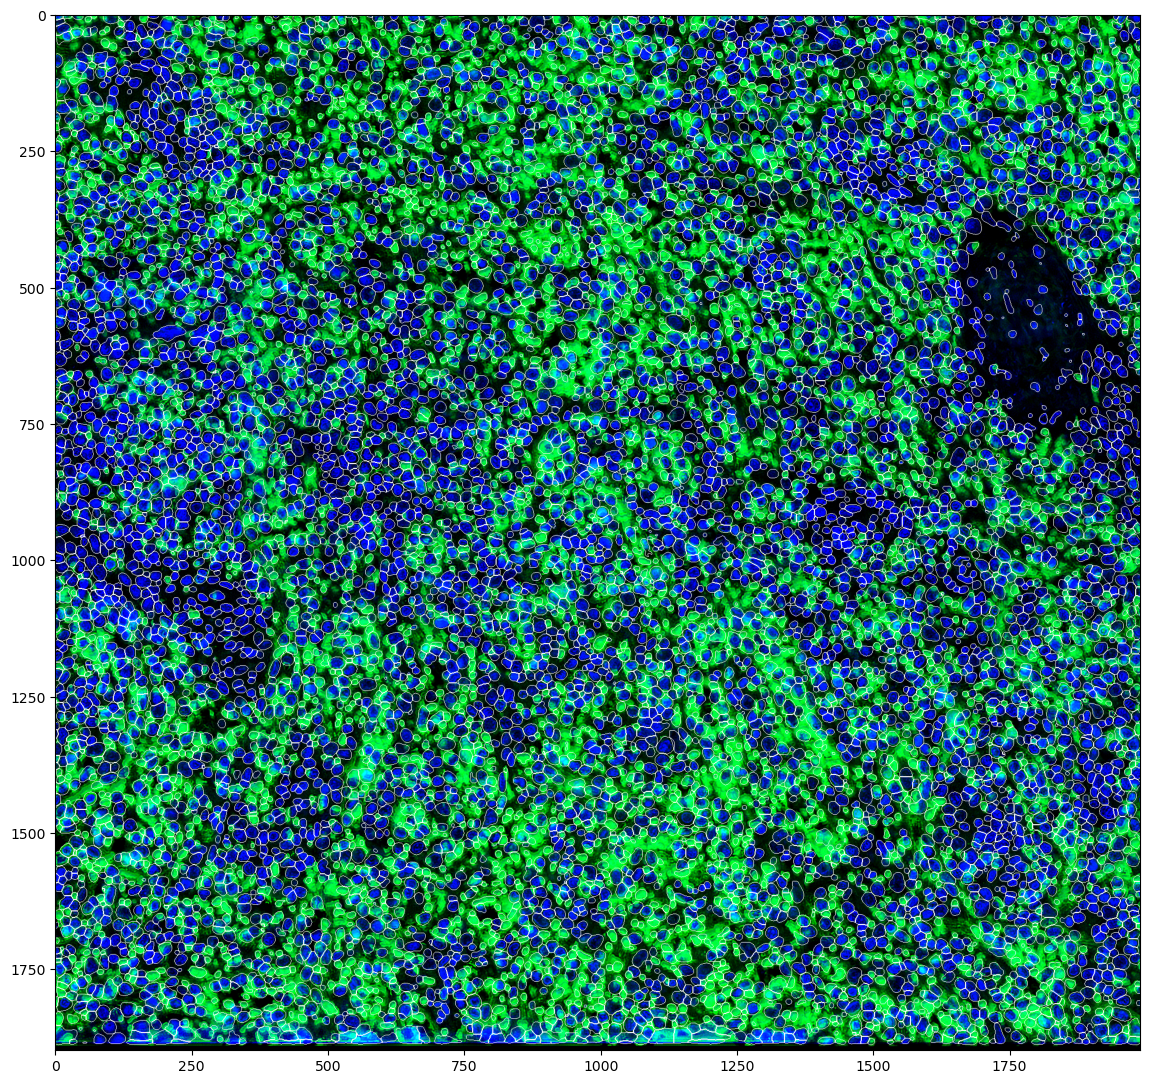

In [16]:
fov_to_see = 6

fov_to_display = io_utils.remove_file_extensions([fovs[fov_to_see]])[0]

fov_overlay = plot_utils.create_overlay(
    fov=fov_to_display,
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    img_overlay_chans=['nuclear_channel', 'membrane_channel'],
    seg_overlay_comp='whole_cell'
)


plt.figure(figsize = (14,14))
plt.imshow(fov_overlay)

Save the overlaid segmentation labels for each fov (these will not display, but will save in viz_dir).

In [17]:
segmentation_utils.save_segmentation_labels(
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    output_dir=deepcell_visualization_dir,
    fovs=io_utils.remove_file_extensions(fovs),
    channels=['nuclear_channel', 'membrane_channel']
)

## 6. Visualize and save stitched segmentation masks

Define the function

In [15]:
def stitch_tiles(tiles_folder, num_tiles_width, num_tiles_height, tile_width, tile_height, output_filename):

    stitched_image = Image.new('RGB', (num_tiles_width * tile_width, num_tiles_height * tile_height))

    tile_index = 0
    
    for x in range(num_tiles_width):
        for y in range(num_tiles_height):

            left = x * tile_width
            upper = y * tile_height
            tile_path = os.path.join(tiles_folder, f'fov{tile_index}_nuclear_channel_membrane_channel_overlay.tiff')
            tile = Image.open(tile_path)
            stitched_image.paste(tile, (left, upper))

            tile_index += 1

    # Save the stitched image
    stitched_image.save(tiles_folder+output_filename)


Enter the variables.

In [ ]:
tiles_folder = '../data/LN_/segmentation/deepcell_visualization'
num_tiles_width = 7  # Adjust based on how many tiles in the width
num_tiles_height = 9  # Adjust based on how many tiles in the height
tile_width = 1500  # Width of each tile
tile_height = 1427  # Height of each tile
output_filename = "/stitched_nuc_mem.tif"

stitch_tiles(tiles_folder, num_tiles_width, num_tiles_height, tile_width, tile_height, output_filename)

Visualize the results.

In [ ]:
from tifffile import imread
image = imread(deepcell_visualization_dir+output_filename)
plt.figure(figsize = (25,25))
plt.imshow(image)

## 7. Extract segmentation data

For a full list of features extracted, please refer to the cell table section of: https://ark-analysis.readthedocs.io/en/latest/_rtd/data_types.html

In [18]:
# set to True to add nuclear cell properties to the expression matrix
nuclear_counts = True

# set to True to bypass expensive cell property calculations
# only cell label, size, and centroid will be extracted if True
fast_extraction = True

Extract the segmented imaging data to create normalized and transformed expression matrices.  Note that if you're loading your own dataset, all the imaging data must be in the same folder with each fov given its own folder and all fovs having the same channels.

In [19]:

cell_table_size_normalized, cell_table_arcsinh_transformed = \
    marker_quantification.generate_cell_table(segmentation_dir=deepcell_output_dir,
                                              tiff_dir=tiff_dir,
                                              img_sub_folder=None,
                                              fovs=fovs,
                                              extraction='center_weighting',
                                              nuclear_counts=nuclear_counts,
                                              fast_extraction=fast_extraction)

# Set the compression level if desired, ZSTD compression can offer up to a 60-70% reduction in file size.
# NOTE: Compressed `csv` files cannot be opened in Excel. They must be uncompressed beforehand.
compression = None

# Uncomment the line below to allow for compressed `csv` files.
# compression = {"method": "zstd", "level": 3}

cell_table_size_normalized.to_csv(os.path.join(cell_table_dir, 'cell_table_size_normalized.csv'),
                                  compression=compression, index=False)
cell_table_arcsinh_transformed.to_csv(os.path.join(cell_table_dir, 'cell_table_arcsinh_transformed.csv'),
                                      compression=compression, index=False)